In [1]:
import pickle
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
#print(tf.version)
import bz2
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
import seaborn as sns
import itertools
warnings.filterwarnings('ignore')

In [2]:
import os
import os.path
from glob import glob
import random
import shutil
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
#from kerashypetune import KerasGridSearch

In [3]:
def FIPS_function(row):
    state = str(row['stateFip']).zfill(2)
    county = str(row['countyFip']).zfill(3)
    return str(state + county)

### --- Note ---
- Original load, but I used different dfs throughout on different parts.
- Wanted to make sure I was doing it correctly before I ran on the whole

In [4]:
bz_file = bz2.BZ2File("feeFiFoFum.pbz2",'rb')
df = pd.read_pickle(bz_file)
df.head()

,dates,JHU_ConfirmedCases.data,NYT_ConfirmedCases.data,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,...,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,countyStateName,stateFip,countyFip,pm25
0,2020-03-19,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,...,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
1,2020-03-20,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,...,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
2,2020-03-21,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,...,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
3,2020-03-22,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,...,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551
4,2020-03-23,1.0,1.0,0.0,0.0,0,24527.0,5343.0,11868.0,12673.0,...,21415,179,87,39,122,2555,"Abbeville County, South Carolina",45,001,9.618551


In [5]:
### Drop non-numeric and unnecessary columns
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']
df.drop(cols, axis=1, inplace=True)

## --------- Update EDA ----------

- I can do some plots, and then suggestions for other EDA i could include???
- I think I can run it on the entire dataset, it just takes a while and wanted to make sure it   was right before I did it

## df2 is used throughout EDA

In [6]:
print(df.shape); print(1879589/10000)

(1879589, 88)
187.9589


In [7]:
df2 = df.copy(188)
df2.head(3)

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,...,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25
0,2020-03-19,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
1,2020-03-20,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
2,2020-03-21,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551


In [8]:
##function for above and below a threshold

def get_above_threshold(dff,thresh):
    corr_mtrx = dff.corr()
    corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns)
    numCols = corr_mtrx.shape[0]
    above_threshold = []
    
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] > thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    return above_threshold

def get_below_threshold(dff,thresh):
    corr_mtrx = dff.corr()
    corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns)
    numCols = corr_mtrx.shape[0]
    above_threshold = []
    
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] < thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    return above_threshold

In [10]:
## raw correlations
df2_corrs = get_above_threshold(df2,0.9)
df2_corrs

[['unitsInStructure', 'healthInsTotal', 0.994129629869046],
 ['unitsInStructure', 'healthInsNativeWith', 0.9949704848079665],
 ['totalTrans', 'unitsInStructure', 0.9929803019216017],
 ['totalTrans', 'householdsTotal', 0.9963845175005094],
 ['totalTrans', 'householdStructuresTotal', 0.9963845175005094],
 ['totalTrans', 'houseWith65', 0.9808301889300902],
 ['totalTrans', 'houseNonfamNo65', 0.9649106176366248],
 ['totalTrans', 'houseNonfam65', 0.9476931509873331],
 ['totalTrans', 'houseNo65', 0.9961388201760542],
 ['totalTrans', 'houseFamilyNo65', 0.9969163007655882],
 ['totalTrans', 'houseFamily65', 0.984013337910157],
 ['totalTrans', 'house2+with65', 0.9832598746394784],
 ['totalTrans', 'house2+No65', 0.9981020106641629],
 ['totalTrans', 'healthInsTotal', 0.9981848496197337],
 ['totalTrans', 'healthInsNativeWith', 0.9908344793728892],
 ['totalTrans', 'healthInsForeignNoncitWith', 0.9285206990844674],
 ['totalTrans', 'healthInsForeignNatWith', 0.907675662189093],
 ['totalMoved', 'unitsIn

In [11]:
### pca here or after conversions?

#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(x_p)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2'])

# ------------- Clean up -----------
- Followed Noah's notebook
- back to original dataset for clean up

In [12]:
### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county
counties = pd.read_csv('2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'longitude',
                        'INTPTLAT': 'latitude'}, inplace=True)

counties = counties[['GEOID', 'latitude', 'longitude' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

### Replace dates with monotonically increasing integers starting with the minimum date
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
print(min_date, max_date, df.dates.dtype)
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

###Replace the integer representation of date with sin and cosine encoding

cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

2020-03-11 00:00:00 2022-01-16 00:00:00 datetime64[ns]


In [13]:
###Get the feature column for latitude and longitude
# crossed_latlong = pp.get_latlong_fc(df)

lat_buckets = list(np.linspace(df.latitude.min(), df.latitude.max(),100))
long_buckets = list(np.linspace(df.longitude.min(), df.longitude.max(),100))

#make feature columns
lat_fc = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'),lat_buckets)
long_fc= tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),long_buckets)
    
# crossed columns tell the model how the features relate
crossed_latlong = tf.feature_column.crossed_column(keys=[lat_fc, long_fc], hash_bucket_size=1000) # No precise rule, maybe 1000 buckets will be good?
    
embedded_latlong = tf.feature_column.embedding_column(crossed_latlong,9)

feature_layer = tf.keras.layers.DenseFeatures(embedded_latlong)

df[['geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']] = feature_layer({'latitude': df.latitude, 'longitude': df.longitude})

# df.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [14]:
### normalize the data
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25', 'latitude',
       'longitude']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos', 'geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)

In [15]:
print(df.shape); df.head(2)

(1879589, 102)


,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
1,45001,1.0,0.0,0.154309,0.988023,0.015492,0.999880,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


# ----------- PCA -------------
- need to run on the entirety of it 
- df_pca is used throughout the pca portion

In [16]:
###https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

#df_pca = df.copy() # if ran on the whole, it returns:
 # ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
    
df_pca = df.head(18795)
print(df_pca.shape);df_pca.head(1)

### PCA
target = 'JHU_ConfirmedCases.data'
features = list(df_pca.columns); features.remove(target)
feature_columns = [tf.feature_column.numeric_column(i) for i in features]

x_p = df_pca.loc[:, features].values
x_p = StandardScaler().fit_transform(x_p)
y_p = df_pca.loc[:,[target]].values

pca = PCA(n_components=0.95)
principalComponents = pca.fit_transform(x_p)
principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, df_pca[[target]]], axis = 1)
finalDf.head(3)

(18795, 102)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,JHU_ConfirmedCases.data
0,-2.795830,-2.048889,-0.719763,0.089960,1.185641,-1.150630,-1.513858,1.440378,-0.055015,0.363353,...,-0.141003,0.561497,-0.619157,1.070254,-0.654321,2.527055,1.587043,-0.593245,0.083959,1.0
1,-2.793556,-2.007706,-0.720598,-0.053520,0.957493,-0.961482,-1.129371,1.454614,-0.268009,0.293731,...,-0.077118,0.492185,-0.431755,1.065521,-0.455071,2.755030,1.360857,-0.455704,0.117763,1.0
2,-2.773668,-1.882110,-0.735432,-0.129517,0.955638,-0.900280,-1.156049,1.518579,-0.267944,0.271753,...,-0.092727,0.402134,-0.390746,0.946728,-0.257748,2.858110,1.264480,-0.372915,0.025240,1.0


In [17]:
var_expln = list(pca.explained_variance_ratio_)
var_expln.sort(reverse=True)
var_expln[0:3]

[0.4185305452508023, 0.07799606078238032, 0.05644406888633959]

Text(0, 0.5, 'pc-2')

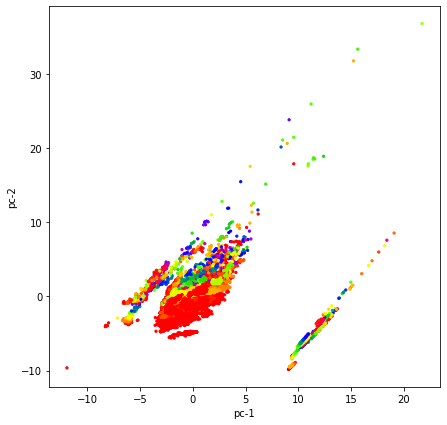

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(finalDf[1],finalDf[2],c=finalDf['JHU_ConfirmedCases.data'],cmap='prism', s =5)
plt.xlabel('pc-1')
plt.ylabel('pc-2')

In [19]:
#total size /1000 = 18795 then /2 = 9397.5 then /2 = 4698

### another look at correlation
- used pca_df since it was smaller til i make sure it's right

In [20]:
## correlations

dfpca_corrs = get_above_threshold(df_pca,0.9)
dfpca_corrs[0:10]

[['unitsInStructure', 'healthInsTotal', 0.9978549866058533],
 ['unitsInStructure', 'healthInsNativeWith', 0.9953833218744516],
 ['unitsInStructure', 'healthInsForeignNoncitWith', 0.9473192178744134],
 ['unitsInStructure', 'healthInsForeignNatWith', 0.9417778011262916],
 ['unitsInStructure', 'healthInsForeignNatNo', 0.979872200637409],
 ['totalTrans', 'unitsInStructure', 0.9973157007980598],
 ['totalTrans', 'householdsTotal', 0.9985537485743665],
 ['totalTrans', 'householdStructuresTotal', 0.9985537485743665],
 ['totalTrans', 'houseWith65', 0.9924844064824354],
 ['totalTrans', 'houseNonfamNo65', 0.9901929709862141]]

#### extra not needed, article just continued with this stuff

In [21]:
### logistic regression wihtout pca

#logisticRegr = LogisticRegression()
#logisticRegr.fit(train_x_dfp,train_y_dfp)

#y_train_hat =logisticRegr.predict(test_x_dfp)
#train_accuracy = accuracy_score(test_y_dfp, y_train_hat)*100
#print('"Accuracy for our Training dataset with PCA is: %.4f %%' % train_accuracy)

#y_test_hat=logisticRegr.predict(test_x_dfp)
#test_accuracy=accuracy_score(test_y_dfp,y_test_hat)*100
#print("Accuracy for our Testing dataset with tuning is : {:.3f}%".format(test_accuracy) )

In [22]:
### logistic with pca 
#scaler = StandardScaler()

#X_train_pca = scaler.transform(train_x_dfp)
#X_test_pca = scaler.transform(test_x_dfp)

#logisticRegr = LogisticRegression()
#logisticRegr.fit(X_train_pca,train_y_dfp)

#y_train_hat =logisticRegr.predict(X_train_pca)
#train_accuracy = accuracy_score(train_y_dfp, y_train_hat)*100
#print('"Accuracy for our Training dataset with PCA is: %.4f %%' % train_accuracy)

#y_test_hat=logisticRegr.predict(X_test_pca)
#test_accuracy=accuracy_score(test_y_dfp,y_test_hat)*100
#print("Accuracy for our Testing dataset with PCA is : {:.3f}%".format(test_accuracy) )

In [23]:
### linear regression

#model = LinearRegression()
#model.fit(X_train, y_train)
#print(model.coef_);print(model.intercept_)


#pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])
#predictions = model.predict(X_test)

#plt.scatter(y_test, predictions)
#plt.hist(y_test - predictions)

#metrics.mean_absolute_error(y_test, predictions)
#metrics.mean_squared_error(y_test, predictions)
#np.sqrt(metrics.mean_squared_error(y_test, predictions))

# ------- linear regression / baseline ------
- i think
- had trouble with reading through all files with date adjustments
- need to run on whole dataset and separate 1 day every 30 for x/y

In [24]:
1879589/100

18795.89

In [25]:
## reduced size
df3 = df.head(18795)
print(df3.shape);df3.head(1)

(18795, 102)


,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


### changed to df3 until i figure out links

In [26]:
### prepare the data for training
days_of_history = 30
days_to_predict = 1

fips = df3.fips.unique() #changed to df3

def xy_generator(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            data_matrix = data.iloc[i - days: i, 1:].to_numpy()
            yield data_matrix

In [27]:
def xy_generator_2(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            testing_data = data.iloc[i - days: i, 1:]
            yield testing_data

In [28]:
Xi = []
j = 0

N_SAMPLES = 200

for i, x in enumerate(xy_generator(df3)):  #chnaged to df3
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.save(os.path.join('.','data', f'x_{j}.npy'), X)
        j += 1
        Xi = []
if Xi:
    X = np.asarray(Xi)
    np.save(os.path.join('.','data', f'x_{j}.npy'), X)

0 

In [29]:
x = np.load('./data/x_0.npy')
x.shape

(200, 31, 101)

In [30]:
RANDOM_SEED = 42
def set_seed():
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
set_seed()

In [31]:
x_files = glob('./data/x_*.npy')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))

90
62
13
15


In [32]:
train_files = glob('./data/train/x_*.npy')
eval_files = glob('./data/eval/x_*.npy')
test_files = glob('./data/test/x_*.npy')

n_readers = 5
n_parse_threads = 5
len_array = 995

def create_generator(files, cycle_length=5):
    set_seed()
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i+cycle_length]
        np_arrays = [np.load(s) for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        np.random.shuffle(np_array)
        yield np_array
            

def split_xy(np_array):
    X = np_array[:,:-1,:]
    y = np_array[:,-1:,:1]
    return X,y
        
    
train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32 )
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32 )
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32 )
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

In [33]:
# run linear regression with these? or not necessary?
## or how would i do that with a prefetch dataset
 ## that was the error I kept coming across

### ??? Trying to get URL's from github to run with all files ???

In [35]:
type(train_ds) #eval_ds,test_ds

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [36]:
#train_files = glob('./data/train/x_*.npy')
#eval_files = glob('./data/eval/x_*.npy')
#test_files = glob('./data/test/x_*.npy')

#train_url = 'https://github.com/FuzzyPhoton/DS-capstone-pt1/tree/main/experiments/noah/data/train/x_*.npy'
#test_url = 'https://github.com/FuzzyPhoton/DS-capstone-pt1/tree/main/experiments/noah/data/test/x_*.npy'
#eval_url = 'https://github.com/FuzzyPhoton/DS-capstone-pt1/tree/main/experiments/noah/data/eval/x_*.npy'

#train_files = glob(train_url)
#eval_files = glob(eval_url)
#test_files = glob(test_url)

#n_readers = 5
#n_parse_threads = 5
#len_array = 995       
    
#train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32)
#train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

#val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32)
#val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

#test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32)
#test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

In [37]:
def linear_reg(x):
   return A * x + b
def mean_square_error(y_pred, y_true):
   return tf.reduce_mean(tf.square(y_pred - y_true))

learning_rate = 0.0
optimizer = tf.optimizers.SGD(learning_rate)

def run_optimization():
   with tf.GradientTape() as g:
      pred = linear_reg(X)
      loss = mean_square_error(pred, Y)
   gradients = g.gradient(loss, [A, b])
   optimizer.apply_gradients(zip(gradients, [A, b]))

In [38]:
# https://medium.com/analytics-vidhya/linear-regression-with-tensorflow-161f35a6ef3f

#num_features = 102
#W = tf.Variable([tf.random.normal(shape=[num_features,1])])
#B = tf.Variable(0.05)

#perform matrix multiplication and predicted y
#xW = tf.matmul(train_ds, W)
#ymodel = tf.add(xW, B)
#calculate error aka loss function
#error = tf.reduce_sum(tf.square(eval_ds-ymodel))
       
#define optimizer. In this case gradient descent
#optimizer = tf.train.GradientDescentOptimizer(0.00001)
#train = optimizer.minimize(error)

## took a different approach to building the datasets, but lmk if it's off
- https://www.guru99.com/linear-regression-tensorflow.html

### works, but need to come back and get right x/y 
- need to sort x and y to 30 days to predict 1. Need to run on the entire dataset.

## ------ DF4 is used throughout linear regression ------

In [39]:
df.shape[0]/1000

1879.589

In [40]:
df4 = df.head(1879)
df4.head(2)

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
1,45001,1.0,0.0,0.154309,0.988023,0.015492,0.999880,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


In [48]:
## function to automate that day split

def days_to_predict(dff,numDays):
    train = pd.DataFrame(); test = pd.DataFrame()
    numDays = numDays+1

    for i in range(len(dff)):
        if i%numDays == 0:
            test = test.append(dff.loc[[i]], ignore_index = True)
        else:
            train = train.append(dff.loc[[i]], ignore_index = True)
    return train,test

In [49]:
train_df4, test_df4 = days_to_predict(df4,30)
train_df4.head(3) #;train_df4.head(3)

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.154309,0.988023,0.015492,0.999880,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
1,45001,1.0,0.0,0.171293,0.985220,0.017213,0.999852,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
2,45001,1.0,0.0,0.188227,0.982126,0.018934,0.999821,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


In [50]:
test_df4.head(3)

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
1,45001,17.0,0.0,0.622047,0.782980,0.067085,0.997747,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
2,45001,36.0,0.0,0.933837,0.357698,0.120208,0.992749,0.140233,0.265235,0.319876,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


In [57]:
#training_size = int(len(df4) * 0.8)
#train_df4 = df4.iloc[:training_size, :]
#test_df4 = df4.iloc[training_size:, :]

def input_fn(dataset, batch_size=128, num_epochs=None, shuffle=True):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
    x = dataset[features],
    y = dataset[target],
    batch_size=batch_size,
    num_epochs=num_epochs,
    shuffle=shuffle )

In [58]:
## https://www.h2kinfosys.com/blog/linear-regression-using-tensorflow-with-examples/
target = 'JHU_ConfirmedCases.data'
features = list(df4.columns); features.remove(target)
feature_columns = [tf.feature_column.numeric_column(i) for i in features]

estimator = tf.estimator.LinearRegressor(feature_columns=feature_columns, model_dir='LinRegTrain')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'LinRegTrain', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [59]:
#train the model with 2000 steps
estimator.train(input_fn=input_fn(train_df4, num_epochs=None), steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from LinRegTrain/model.ckpt-8000


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key linear/linear_model/geo0/weights not found in checkpoint
	 [[node save/RestoreV2 (defined at /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py:1497) ]]

Original stack trace for 'save/RestoreV2':
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 362, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 265, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 540, in execute_request
    self.do_execute(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell
    result = self._run_cell(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2923, in _run_cell
    return runner(coro)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-9b557e7ed94c>", line 2, in <module>
    estimator.train(input_fn=input_fn(train_df4, num_epochs=None), steps=2000)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 349, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1175, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1206, in _train_model_default
    return self._train_with_estimator_spec(estimator_spec, worker_hooks,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1497, in _train_with_estimator_spec
    with training.MonitoredTrainingSession(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 601, in MonitoredTrainingSession
    return MonitoredSession(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 1034, in __init__
    super(MonitoredSession, self).__init__(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 749, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 1231, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 1236, in _create_session
    return self._sess_creator.create_session()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 902, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 660, in create_session
    self._scaffold.finalize()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 243, in finalize
    self._saver.build()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 847, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 875, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 508, in _build_internal
    restore_op = self._AddShardedRestoreOps(filename_tensor, per_device,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 382, in _AddShardedRestoreOps
    self._AddRestoreOps(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 334, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 582, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1508, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3528, in _create_op_internal
    ret = Operation(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()


In [56]:
#evaluate the model
ev = estimator.evaluate(input_fn=input_fn(test_df4, num_epochs=10, shuffle=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-02-17T20:20:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from LinRegTrain/model.ckpt-8000


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key linear/linear_model/geo0/weights not found in checkpoint
	 [[node save/RestoreV2 (defined at /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py:1640) ]]

Original stack trace for 'save/RestoreV2':
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 362, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 265, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 540, in execute_request
    self.do_execute(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell
    result = self._run_cell(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2923, in _run_cell
    return runner(coro)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-b861c468c1fb>", line 2, in <module>
    ev = estimator.evaluate(input_fn=input_fn(test_df4, num_epochs=10, shuffle=True))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 461, in evaluate
    return self._actual_eval(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 510, in _actual_eval
    return _evaluate()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 493, in _evaluate
    return self._evaluate_run(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1640, in _evaluate_run
    eval_results = evaluation._evaluate_once(  # pylint: disable=protected-access
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/evaluation.py", line 268, in _evaluate_once
    with monitored_session.MonitoredSession(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 1034, in __init__
    super(MonitoredSession, self).__init__(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 749, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 1231, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 1236, in _create_session
    return self._sess_creator.create_session()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 902, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 660, in create_session
    self._scaffold.finalize()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/monitored_session.py", line 235, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 606, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 835, in __init__
    self.build()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 847, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 875, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 508, in _build_internal
    restore_op = self._AddShardedRestoreOps(filename_tensor, per_device,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 382, in _AddShardedRestoreOps
    self._AddRestoreOps(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 334, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 582, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1508, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3528, in _create_op_internal
    ret = Operation(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
train_df4[target].describe()

In [ ]:
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))

In [ ]:
### is this suppuse to go where it is in the line below??
test_df4.shape[0]

In [ ]:
y_pred_df4 = estimator.predict(input_fn=input_fn(test_df4,num_epochs=None))
predictions = list(p["predictions"] for p in itertools.islice(y_pred_df4, test_df4.shape[0]))
#print("Predictions: {}".format(str(predictions)))

In [ ]:
ypred_df4 = [x[0] for x in predictions]
ypred_df4[0:5]

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test_df4[target], ypred_df4)
print(MAE)

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(ypred_df4,test_df4[target],s =5, cmap='prism')
plt.xlabel('y')
plt.ylabel('ypred')

In [ ]:
# plots?

### another attempt, not needed

In [ ]:
### https://www.machinelearningmindset.com/linear-regression-with-tensorflow/

#p=0.8
#trainDataset = df4.sample(frac=p,random_state=0)
#testDataset = df4.drop(trainDataset.index)

#target = 'JHU_ConfirmedCases.data'
#features = list(df4.columns)
#feature_columns = [tf.feature_column.numeric_column(i) for i in features]

#trainInput = trainDataset[features]; testInput = testDataset[features]
#trainTarget = trainDataset[target]; testTarget = testDataset[target]

In [ ]:
#trainInput = trainInput.T; testInput = testInput.T

In [ ]:
### https://techbrij.com/tensorflow-linear-regression-model

# Define layer
#layer0 = tf.keras.layers.Dense(units=1, input_shape=[102])
#model = tf.keras.Sequential([layer0])
 
# Compile model
#model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1))
 
# Train the model
#history = model.fit(trainInput, testInput, epochs=100, verbose=False)
 
# Prediction
#print('Prediction: {}'.format(model.predict([10])))
 
# Get weight and bias
#weights = layer0.get_weights()
#print('weight: {} bias: {}'.format(weights[0], weights[1]))